# MEG data loading and pre-processing 

### Packages import

Packages are Python librairies, i.e. files that contain pre-written functions. We need to import the packages before using the functions that they include. For our purpose (MEG/EEG data analysis), most of the functions will be included in the MNE package, but we may have to use other packages too.

In [1]:
! pip install mne 
# I know we said this is bad practice, but let's do it anyways so we don't have to open any terminal ;)
! pip install scikit-learn --user

import mne # Here we import mne, the package that will contain most of the function that we will use today.
from mne.datasets.brainstorm import bst_raw # It is possible to import functions individually. This is helpful since it 
                                            # saves time, memory, and makes the calls to the function easier.
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
%matplotlib notebook
# ^ This last line lets us use the interactive plots in Jupyter

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Loading the data

In [2]:
data_path = bst_raw.data_path() # The function bst_raw downloads the Brainstorm tutorial dataset 
                                # and stores the folder's path in "data_path".
                                # It is possible to specify a destination in the parenthesis : data_path('/home/yann/mne-tuto')
                                # (don't forget to double the backslashes in windows)

Successfully extracted to: ['C:\\Users\\Karim\\Tuto-MNE\\MNE-brainstorm-data\\bst_raw']


In [3]:
raw_fname = data_path + '/MEG/bst_raw/' + \
                        'subj001_somatosensory_20111109_01_AUX-f_raw.fif' # Now, we will access the file 
                                                                          # containing the MEG data in .fif format
# If you want to use your own data instead of the tutorial data, put the full path to your datafile in raw_fname

raw = mne.io.read_raw_fif(raw_fname, preload=True) # Let's load the datafile and store it in "raw", an MNE data object.
                                                   # If your data is not in .fif, there are other MNE
                                                   # functions that can open .cnt, .edf, .gdf and so on...
# Here is a list of the supported formats (with corresponding functions) : https://www.martinos.org/mne/stable/manual/io.html#creating-mne-data-structures-from-arbitrary-data-from-memory

Opening raw data file C:\Users\Karim\Tuto-MNE\MNE-brainstorm-data\bst_raw\MEG\bst_raw\subj001_somatosensory_20111109_01_AUX-f_raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 431999 =      0.000 ...   359.999 secs
Ready.
Current compensation grade : 3
Reading 0 ... 431999  =      0.000 ...   359.999 secs...


While the tutorial dataset is downloading, let's have a look at what is this data, and what we will do with it.
The data comes from Brainstorm's MEG median nerve tutorial (CTF) : https://neuroimage.usc.edu/brainstorm/Tutorials/MedianNerveCtf



Experiment : 
- One subject, one acquisition run of 6 minutes
- The run contains 200 electric stimulations randomly distributed between left and right:
    - 102 stimulations of the left hand
    - 98 stimulations of the right hand
- Inter-stimulus interval: jittered between [1500, 2000]ms


Data : 
- Acquisition at 1200Hz, with a CTF 275 system, subject in seating position
- Recorded at the Montreal Neurological Institute in November 2011
- Anti-aliasing low-pass filter at 300Hz, files saved with the 3rd order gradient
- Recorded channels (302):
    - 1 Stim channel indicating the presentation times of the stimuli: UPPT001 (#1)
    - 26 MEG reference sensors (#3-#28)
    - 272 MEG axial gradiometers (#29-#300)
    - 1 ECG bipolar (#301)
    - 1 vertical EOG bipolar (#302)
    - 1 Unused channels (#2)


In this tutorial, we will see the basic steps of MEG pre-processing : frequency filtering and artifact removal using ICA.
In the next notebook, we will use MNE functions to analyse our data. First we will compare the topography and power of oscillations between left and right-hand stimulation. Then we will compare the time-course of the evoked response (ERF) of both stimulation. 

### MNE data objects

The MNE data objects contains the data + some information (sampling frequency, number of channels etc...). It is very convenient since most MNE functions will be applied directly on this object, and you can access everything in the same place. 

In [4]:
raw.info # For example, you can use the method "info" to look at the informations about your data

<Info | 24 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float64 | 1.5
    ch_names : list | UPPT001, SCLK01-177, BG1-4408, BG2-4408, BG3-4408, ...
    chs : list | 302 items (REF_MEG: 26, STIM: 1, MISC: 1, EEG: 2, MAG: 272)
    comps : list | 5 items
    ctf_head_t : Transform | 3 items
    custom_ref_applied : bool | False
    dev_ctf_t : Transform | 3 items
    dev_head_t : Transform | 3 items
    dig : list | 5 items
    events : list | 0 items
    experimenter : str | 7 items
    file_id : dict | 4 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 1 items
    lowpass : float | 600.0 Hz
    meas_date : list | 2011-11-09 15:11:00 GMT
    meas_id : dict | 4 items
    nchan : int | 302
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 1200.0 Hz
    subject_info : dict | 1 items
    acq_pars : NoneType
    acq_stim : NoneType
    description : NoneType
    hpi_subsystem : NoneType
    kit_system_

In [5]:
raw.info.get('sfreq') # Or you can access each field separately by using get() (here, we ask for the sampling frequency)

1200.0

<IPython.core.display.Javascript object>


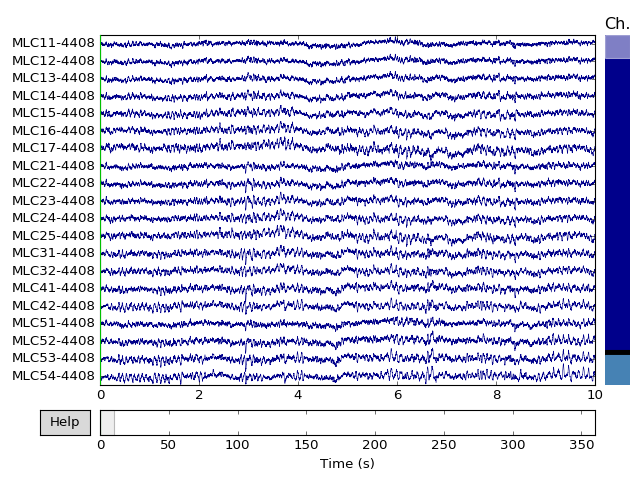

In [6]:
raw.plot(); # You can also plot the timeseries of your data and scroll to explore them visually.
           # The plot method can take many arguments to help you plot the data the way you want.
           # Any transformation commanded by these arguments (e.g. filtering) will ONLY apply to the plotted data, 
           # the content of "raw" will be left untouched.

<IPython.core.display.Javascript object>


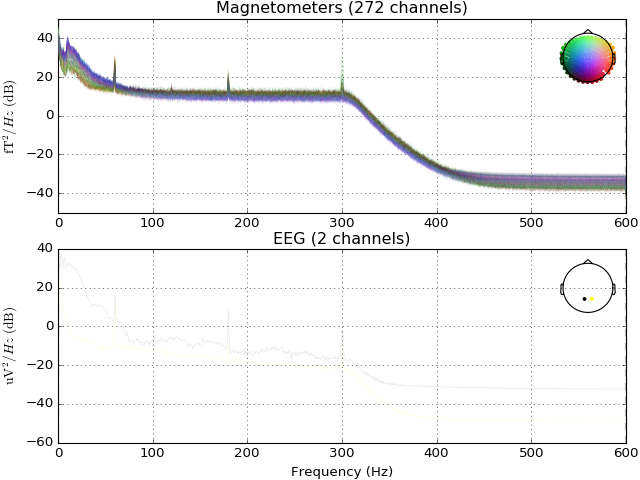

Effective window size : 1.707 (s)
Effective window size : 1.707 (s)


In [7]:
# Let's have a quick look at the spectrum of our data
raw.plot_psd(tmax=60., average=False);

### Filtering

Before doing anything with our data, we usually want to filter them in order to remove specific frequency bands.
1. We want to remove frequencies that are either too low or too high to be meaningful to us
    -> Band-pass filter
2. We want to remove the line noise (i.e. noise generated by the alternative current used to power electric devices)
    -> Notch filter

In [8]:
raw.filter(0.5, 150., fir_design="firwin") # This method applies a bandpass filter to the data in "raw".
                                           # Here, we keep only frequencies between 0.5 and 150Hz, the rest will be attenuated.
    
raw.notch_filter([60, 120], filter_length='auto',phase='zero', fir_design="firwin") # The notch filter will only
                                            # remove certain frequencies. Since in North America the power lines oscillates
                                            # at 60Hz, we will remove this frequency and it's first harmonic, 120Hz.

Setting up band-pass filter from 0.5 - 1.5e+02 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 37.5 Hz
Filter length of 7921 samples (6.601 sec) selected
Setting up band-stop filter
Filter length of 7921 samples (6.601 sec) selected


<Raw  |  subj001_somatosensory_20111109_01_AUX-f_raw.fif, n_channels x n_times : 302 x 432000 (360.0 sec), ~996.1 MB, data loaded>

<IPython.core.display.Javascript object>


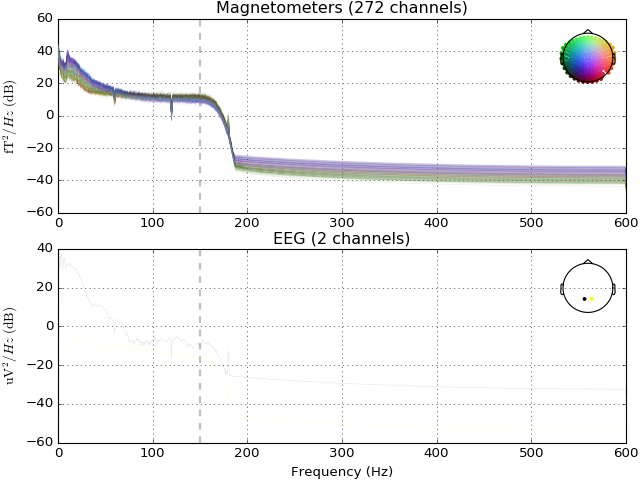

Effective window size : 1.707 (s)
Effective window size : 1.707 (s)


In [9]:
# Plot a new spectrum to see how the signal was modified
raw.plot_psd(tmax=60., average=False);

### ICA decomposition

The next classical step to MEG/EEG pre-processing is to run an Independent Component Analysis (ICA) in order to detect and remove occular and cardiac artifacts from our signal.

In [10]:
ica = mne.preprocessing.ICA(n_components=20, random_state=0).fit(raw, decim=3) # We compute an ICA object from the data.
# The n_components argument defines the number of components that we wish to obtain.
# It is also possible to state that 0<n_components<1, in which case it will define the proportion of variance that 
# we want to be explained by the N components. 

Fitting ICA to data using 274 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Selection by number: 20 components


<IPython.core.display.Javascript object>


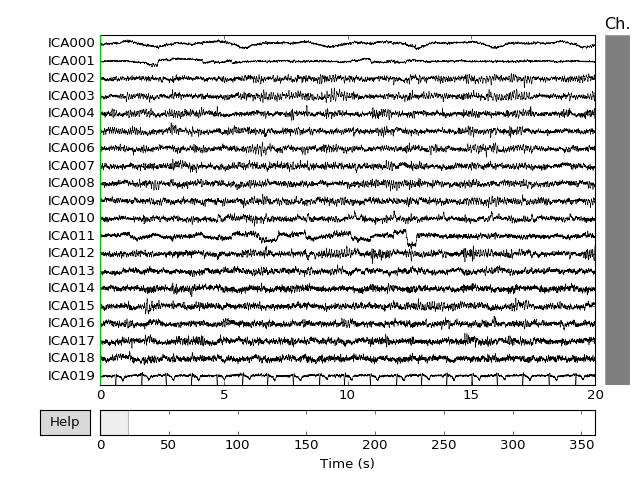

In [11]:
ica.plot_sources(raw); # We can plot our components and explore them visually to get 
                      # an idea of which artifact was captured by which component. What do we see ?

Looking at the above plot, we can guess that the last component (ICA019) captures cardiac activity. ICA001 looks like it has captured ocular blinks.
However, this is kind of arbitrary. Let's confirm our guesses with an automatic method. Hopefully, this dataset has an ECG and EOG channels that will help us find the artifactual components. If it is not the case, this method will still work although it may make more mistakes. 

Using channel EEG057 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz
Filter length of 16384 samples (13.653 sec) selected
Number of ECG events detected : 348 (average pulse 58 / min.)
348 matching events found
Loading data for 348 events and 1201 original time points ...
0 bad epochs dropped


<IPython.core.display.Javascript object>


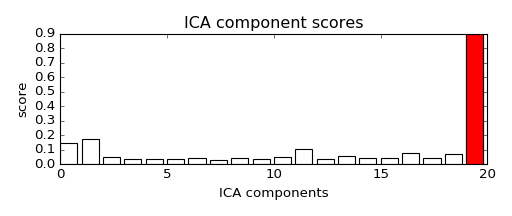

<IPython.core.display.Javascript object>


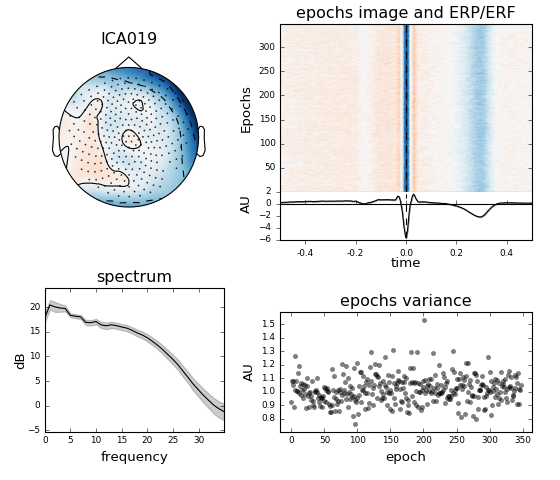

In [12]:
# First, we will start by looking for the component(s) that captured cardiac activity.

ecg_epochs = create_ecg_epochs(raw, ch_name='EEG057') # This function will detect cardiac events (heartbeats) on the ECG signal
                                                      # and store their timestamps in "ecg_epochs".

ecg_inds, ecg_scores = ica.find_bads_ecg(ecg_epochs, ch_name='EEG057') # Now, this function correlates, at the timestamps
                                                      # specified by "ecg_epochs", the activity on EEG057 (our ECG channel) with
                                                      # each ICA component. The component with the greatest correlation is most
                                                      # likely the one we are looking for !

ica.plot_scores(ecg_scores, ecg_inds); # Let's plot the correlations scores for each ICA components. 
                                      # "ecg_inds" contains the indices of components identified as cardiac activity.

ica.plot_properties(ecg_epochs, picks=ecg_inds, psd_args={'fmax': 35.}, # Plot the topography and variance of the components in
                    image_args={'sigma': 1.});

Using channel EEG058 as EOG channel
EOG channel index for this subject is: [301]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz
Filter length of 16384 samples (13.653 sec) selected
Setting up band-pass filter from 1 - 10 Hz
Filter length of 16384 samples (13.653 sec) selected
Now detecting blinks and generating corresponding events
Number of EOG events detected : 32
32 matching events found
Loading data for 32 events and 1201 original time points ...
0 bad epochs dropped
Using channel EEG058 as EOG channel


<IPython.core.display.Javascript object>


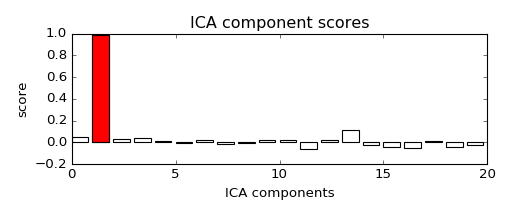

<IPython.core.display.Javascript object>


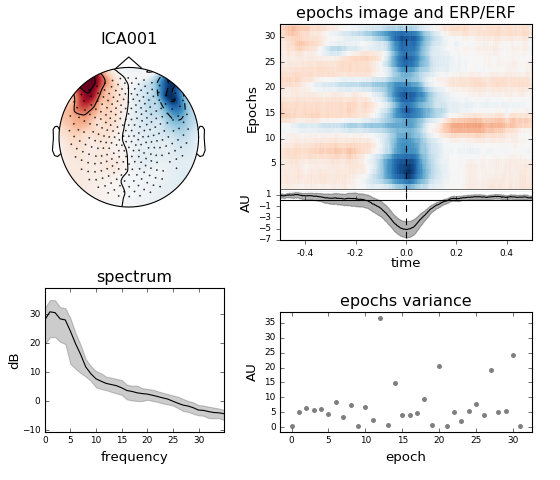

In [13]:
# Now, let's do the same for ocular blinks. Note that two things have changed :
# - The functions used to detect artifacts are now called "eog" instead of "ecg"
# - The channel to which we correlate our components is now EEG058, the EOG channel
eog_epochs = create_eog_epochs(raw, ch_name='EEG058')
eog_inds, eog_scores = ica.find_bads_eog(eog_epochs, ch_name='EEG058')
ica.plot_scores(eog_scores, eog_inds);
ica.plot_properties(eog_epochs, picks=eog_inds, psd_args={'fmax': 35.},
                    image_args={'sigma': 1.});

Transforming to ICA space (20 components)
Zeroing out 1 ICA components
Transforming to ICA space (20 components)
Zeroing out 1 ICA components


<IPython.core.display.Javascript object>


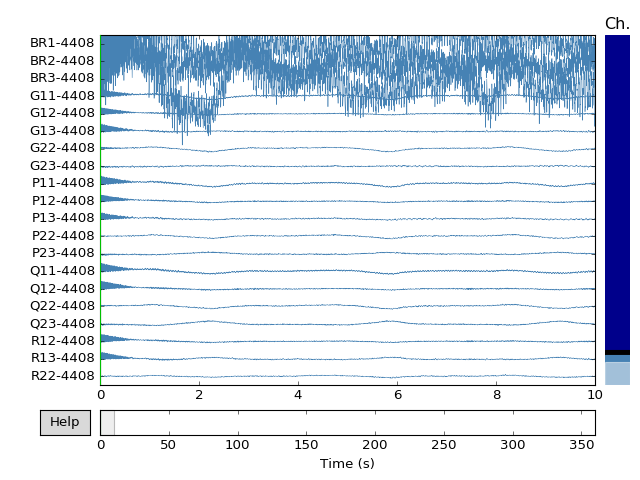

In [14]:
# Finally, we can recompose our signal while excluding the artifactual components : 

#ica.exclude = [1, 19] # We can also index the components individually, useful if we don't agree with the automatic detection

ica.exclude = ecg_inds # Exclude cardiac (ECG) or blinks (EOG) components 
ica.apply(raw) # Here we replace the old raw signal by the ICA recomposition

ica.exclude = eog_inds
ica.apply(raw) # Here we replace the old raw signal by the ICA recomposition


raw.plot(); # Plot the clean signal.

### Saving datasets

In [15]:
# Now that our pre-processing is done, it is time to save our clean dataset

filename = 'clean_dataset'
raw.save(data_path + '\\' + filename + '_raw.fif.gz', overwrite=True) # May be necessary to switch between '\\' and '/' depending on your OS

Overwriting existing file.
Writing C:\Users\Karim\Tuto-MNE\MNE-brainstorm-data\bst_raw\clean_dataset_raw.fif.gz
Closing C:\Users\Karim\Tuto-MNE\MNE-brainstorm-data\bst_raw\clean_dataset_raw.fif.gz [done]
